In [1]:
# Exchange fluxes above the sill
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
sd = 5 # Sill depth
#/Volumes/Extreme SSD/MITgcm outputs
#/work/oceans/wbao/MITgcm_results/iceplume/fjord_test
#/Users/weiyangbao/.CMVolumes/Caviness-group/iceplume/
file1 = xr.open_dataset('/work/oceans/wbao/MITgcm_results/iceplume/1_BaseCase/state_' + str(format(sd,'03d')) + '.nc')
#file2 = xr.open_dataset('/work/oceans/wbao/MITgcm_results/iceplume/newModel_test/stateA_' + str(format(sd,'03d')) + '.nc')
T0 = 0 
Tn = len(file1.T) # T0=275~Tn includes N=5 tidal periods (T=12.4 h)
# X=range(1,120), Xp1=range(1,121), Y=range(30,39), Yp1=range(30,40)
state1 = file1.isel(T=range(T0,Tn)) # Remove the boundary walls and the shelf region
#state2 = file2.isel(T=~file2.get_index("T").duplicated())
grid1 = xr.open_dataset('/work/oceans/wbao/MITgcm_results/iceplume/1_BaseCase/grid_' + str(format(sd,'03d')) + '.nc')
#file2 = xr.open_dataset('/Users/weiyangbao/Documents/Model_outputs/qf-tide-hourly/state_' + str(format(sd,'03d')) + '.nc')
#state2 = file2.isel(X=range(120), Xp1=range(121), Y=range(30,39), Yp1=range(30,40)) # Remove the boundary walls and the shelf region
#grid2 = xr.open_dataset('/Users/weiyangbao/Documents/Model_outputs/qf-tide-hourly/grid_' + str(format(sd,'03d')) + '.nc')

time1 = state1.T.data / 86400
#time2 = state2.T.data / 86400
xs = 5
u1 = state1.U.data[:,:,:,xs]
#u2 = state2.U.data[:,:,:,xs]
#u = state1.U.data[T0,:,5,xs]
dis = state1.X.data
xp1 = state1.Xp1.data

# Area = np.empty([50, 9]) # Cross Y direction
# Area[:10, :] = 100
# Area[10:20, :] = 200
# Area[20:30, :] = 300
# Area[30:40, :] = 800
# Area[40:, :] = 1600

Area = np.empty([90, 10]) # Cross Y direction
Area[:20, :] = 400
Area[20:50, :] = 800
Area[50:, :] = 1200

pt1 = state1.Temp.data[:,:,:,xs]
#pt2 = state2.Temp.data[:,:,:,xs]


s1 = state1.S.data[:,:,:,xs]
#s2 = state2.S.data[:,:,:,xs]



HFacW = grid1.HFacW.data[:,35:45,xs] # vertical fraction of open cell at West face
HFacC = grid1.HFacC
# volume = ds.hFacC * ds.drF * ds.rA
#state1.Xp1.data[72], state1.X.data[71]
#len(time), time
time1

array([ 0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,
        5.5,  6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. , 10.5,
       11. , 11.5, 12. , 12.5, 12. , 12.5, 13. , 13.5, 14. , 14.5, 15. ,
       15.5, 16. , 16.5, 17. , 17.5, 18. , 18.5, 19. , 19.5, 20. , 20.5,
       21. , 21.5, 22. , 22.5, 23. , 23.5, 24. , 24.5, 25. , 25.5, 26. ,
       26.5, 27. , 27.5, 28. , 28.5, 29. , 29.5, 30. , 30.5, 31. , 31.5,
       32. , 32.5, 33. , 33.5, 34. , 34.5, 35. , 35.5, 36. , 36.5, 37. ,
       37.5, 38. , 38.5, 39. , 39.5, 40. , 40.5, 41. , 41.5, 42. , 42.5,
       43. , 43.5, 44. , 44.5, 45. , 45.5, 46. , 46.5, 47. , 47.5, 48. ,
       48.5, 49. , 49.5, 50. , 50.5, 51. , 51.5, 52. , 52.5, 53. , 53.5,
       54. , 54.5, 55. , 55.5, 56. , 56.5, 57. , 57.5, 58. , 58.5, 59. ,
       59.5, 60. ])

In [ ]:
u1[:,15,40], u2[:,15,40], s1[:,15,40], s2[:,15,40]

In [ ]:
fig0, (ax1, ax2, ax3) = plt.subplots(3,1, sharex=True, figsize=(9,9))
ts1 = time1 * 86400
ts2 = time2 * 86400
zi = 40
ax1.plot(ts1,u1[:,zi,40],label="no restart")
ax1.plot(ts2,u2[:,zi,40],lw=.5,label="with restart")
ax1.set_title('$U$', size=15, weight='bold')
ax1.legend(loc = 'best', fontsize=15)
ax1.tick_params(labelsize=15)
ax1.xaxis.set_visible(False)
ax1.set_ylabel('($m/s$)', size=15)


ax2.plot(ts1,pt1[:,zi,40], ts2, pt2[:,zi,40])
ax2.set_title('$Temp$', size=15, weight='bold')
#ax2.legend(loc = 'best', fontsize=15)
ax2.tick_params(labelsize=15)
ax2.xaxis.set_visible(False)
ax2.set_ylabel('($^{\circ}C$)', size=15)



ax3.plot(ts1,s1[:,zi,40], ts2, s2[:,zi,40])
ax3.set_title('$Sal$', size=15, weight='bold')
#ax2.legend(loc = 'best', fontsize=15)
ax3.tick_params(labelsize=15)
ax3.set_ylabel('($psu$)', size=15)

ax3.set_xlabel('Time (s)', size=15)

In [3]:
idx = 130
#dis[idx], xp1[idx], grid1.HFacC.data[:,35,idx]
#grid1.dyF
vol = grid1.HFacC * grid1.drF * grid1.rA # Z Y X
areaC = grid1.HFacC * grid1.drF * grid1.dyF # Z Y X
areaW = grid1.HFacW * grid1.drF * grid1.dyG # Z Y Xp1
temp = state1.Temp.data
s = state1.S.where(HFacC>0)
U = state1.U.where(grid1.HFacW>0)
sW = np.where(HFacC[-1,40,1:] == 0)[-1][0] # Sill west edge index
sE = np.where(HFacC[-1,40,1:] == 0)[-1][-1] # Sill east edge index
sC = np.ceil((sW+sE)/2).astype(int) # Sill crest index (178)
#state1.U.data[5,:,40,178], U[5,:,40,178]
#dis[sW], dis[sE], dis[sC]
#dis[[sW,sC,sE,259]]
#Q = u1[2,:,:] * areaW[:,:,xs].data
sW, sE

(120, 235)

In [4]:
Q1out = np.empty(len(time1))
#Q2out = np.empty(len(time))
Q1in = np.empty(len(time1))
#Q2in = np.empty(len(time))
for t in range(len(time1)):
    Q1 = u1[t,:,:] * areaW.data[:,:,xs]
    #Q2 = u2[t,:,:] * Area * HFacW
    Q1out[t] = Q1[Q1 > 0].sum()
    #Q2out[t] = Q2[Q2 > 0].sum()
    Q1in[t] = Q1[Q1 < 0].sum()
    #Q2in[t] = Q2[Q2 < 0].sum()

np.mean(Q1out[1]+Q1in[1])
#Q1in[[35,38]], Q1out[[35,38]]

250.27275122465653

array([  0.        , 250.27275122, 252.15701196, 249.79714708,
       249.65294377, 250.00259248, 250.21892906, 250.52731827,
       249.8267777 , 250.16643999, 250.09594476, 249.7725564 ,
       250.32672691, 249.78791803, 250.23782875, 249.84894527,
       250.18593008, 249.90922681, 250.17065562, 249.91877488,
       250.14240668, 249.9079635 , 250.14776161, 249.99651741,
       250.07634074, 249.93101757, 250.07634074, 249.93197646,
       250.10876554, 250.01515464, 250.08994805, 250.03130066,
       250.06865025, 250.02340923, 250.07172477, 250.00965737,
       250.01039879, 250.01065104, 250.06526969, 250.02371293,
       249.97710294, 250.0450456 , 250.05094863, 249.93705351,
       250.09422736, 250.01423993, 249.96111763, 250.02209677,
       249.93781632, 250.06699735, 250.03777605, 250.29960452,
       250.00069885, 249.93218572, 249.88572773, 249.84735223,
       249.99910472, 250.06208985, 249.86538528, 249.98731856,
       250.38108678, 250.3604985 , 250.22173717, 249.70

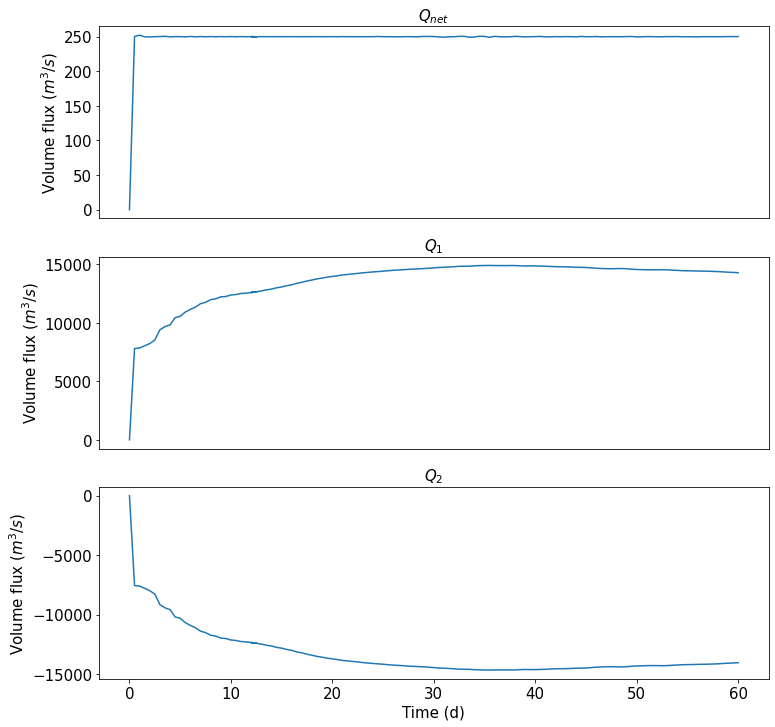

In [5]:
#fig_path = "/Users/weiyangbao/Documents/Results_Figs/VolumeTest/"
#if not os.path.exists(fig_path):
#    os.makedirs(fig_path)

fig, (ax1, ax2, ax3) = plt.subplots(3,1, sharex=True, figsize=(12,12)) 
ax1.plot(time1,Q1in+Q1out, label='ConserveMass OFF')
#ax1.plot(time,Q2in+Q2out, label='ConserveMass ON')
ax1.set_title('$Q_{net}$', size=15, weight='bold')
#ax1.legend(loc = 'best', fontsize=15)
ax1.tick_params(labelsize=15)
ax1.xaxis.set_visible(False)
ax1.set_ylabel('Volume flux ($m^3/s$)', size=15)


ax2.plot(time1,Q1out, label='ConserveMass OFF')
#ax2.plot(time,Q2out, label='ConserveMass ON')
#ax2.axvline(x=275, color='b',lw=2)

ax2.set_title('$Q_1$', size=15, weight='bold')
#ax2.legend(loc = 'best', fontsize=15)
ax2.tick_params(labelsize=15)
ax2.xaxis.set_visible(False)
ax2.set_ylabel('Volume flux ($m^3/s$)', size=15)


ax3.plot(time1,Q1in, label='ConserveMass OFF')
#ax3.plot(time,Q2in, label='ConserveMass ON')
#ax3.axvline(x=275, color='b',lw=2)
ax3.set_title('$Q_2$', size=15, weight='bold')
#ax3.legend(loc = 'best', fontsize=15)
ax3.tick_params(labelsize=15)

ax3.set_xlabel('Time (d)', size=15)
ax3.set_ylabel('Volume flux ($m^3/s$)', size=15)
Q1in+Q1out

In [ ]:
def volflux_ts(file, xidx):
    State01 = xr.open_dataset('/Volumes/Extreme SSD/MITgcm outputs/qf700_strat_high/state_' + str(format(file,'03d')) + '.nc')
    Grid01 = xr.open_dataset('/Volumes/Extreme SSD/MITgcm outputs/qf700_strat_high/grid_' + str(format(file,'03d')) + '.nc')
    T0 = 1 # Start time
    Tn = len(State01.T) # End time
    State = State01.isel(X=range(1,120), Xp1=range(1,121), Y=range(30,39), T=range(T0,Tn))
    Grid = Grid01.isel(X=range(1,120), Xp1=range(1,121), Y=range(30,39))    
    
    time = State.T.data / 86400
    
    Area = np.empty([50, 9]) # Cross Y direction
    Area[:10, :] = 100
    Area[10:20, :] = 200
    Area[20:30, :] = 300
    Area[30:40, :] = 800
    Area[40:, :] = 1600

    HFacW = Grid.HFacW.data[:,:,xidx] # vertical fraction of open cell at West face
    
    Q1 = np.empty(len(time))
    Q2 = np.empty(len(time))
    for t in range(len(time)):
        Q = State.U.data[t,:,:,xidx] * Area * HFacW
        Q1[t] = Q[Q > 0].sum()
        Q2[t] = Q[Q < 0].sum()
    
    return time, Q1, Q2

In [ ]:
prof = np.array([1,2,3,4])
hsr = np.array([9, 12, 15, 18]) / 150
xi = 47
fig1 = plt.figure(figsize=(10,10))
fig1.tight_layout()

ax1 = fig1.add_subplot(211)
#ax1.axvline(x=4.8, color='k',lw=1.5,ls='--')
ax1.set_xlim([0, 30])
ax1.set_title(r'(a) Down fjord', loc='center', size=15)
#ax1.xaxis.set_visible(False)
ax1.set_ylabel(r'Volume Flux [$m^3/s$]', size=15)
ax1.grid(True)
ax1.set_xticklabels([])
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)



ax2 = fig1.add_subplot(212)
ax2.set_xlim([0, 30])
ax2.set_title(r'(b) Up fjord', loc='center', size=15)
ax2.set_ylabel(r'volume Flux [$m^3/s$]', size=15)
ax2.set_xlabel('Time [d]', size=15)
ax2.grid(True)
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)

#ax3 = fig1.add_subplot(313)
#ax3.set_xlim([0, 30])
#ax3.set_title(r'(c) Net', loc='center', size=15)
#ax3.set_xlabel('Time [d]', size=15)
#ax3.set_ylabel('Heat Flux [J/s]', size=15)
#ax3.grid(True)
#ax3.spines["top"].set_visible(False)
#ax3.spines["right"].set_visible(False)

for i in range(len(prof)):
    ot, qp, qn = volflux_ts(prof[i],xi)
    
    ax1.plot(ot, qp, lw=2, label=str(prof[i]))
    ax1.legend(title=r'case', loc='right', fontsize=12)
    
    ax2.plot(ot, qn, lw=2, label=str(prof[i]))
    ax2.legend(title=r'case', loc='right', fontsize=12)
    
    #ax3.plot(ot, advhp+advhn, lw=2, label=str(hsr[i]))
    #ax3.legend(title=r'$h_s/h$', loc='right', fontsize=12)

In [ ]:
#fig_path = "/Users/weiyangbao/Documents/Results_Figs/VolumeTest/"

fig_path ="/home/1959/Jupyter_Figs/Qsg500n_004/"
if not os.path.exists(fig_path):
    os.makedirs(fig_path)

fig.savefig(fig_path + '/Q_test.png', dpi=200, bbox_inches='tight')    